In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from load_mnist import load_mnist
from collections import OrderedDict

In [2]:
dataset_path = './fashion_mnist'

class FashionMNIST:
    def __init__(self, dataset, filter_class=None, sort=False):
        self.images, self.labels = load_mnist(dataset, dataset_path)
        self.images = self.images.flatten(1)
        self.labels = self.labels.long()
        self.std, self.mean = torch.std_mean(self.images, dim=0)

        # filter and sort
        if filter_class is not None:
            self.images = self.images[self.labels == filter_class]
            self.labels = self.labels[self.labels == filter_class]

        if sort:
            sort_indices = torch.argsort(self.labels)
            self.images = self.images[sort_indices]
            self.labels = self.labels[sort_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = (self.images[index] - self.mean) / (self.std + 1e-10)
        return image, self.labels[index]


In [3]:
# classifier

def FashionMNISTClassifier(num_neurons, activation_type=nn.Identity):
    layers = [nn.Flatten(1)]
    last_layer_neurons = 784

    for i, layer_neurons in enumerate(num_neurons):
        layers.append(nn.Linear(last_layer_neurons, layer_neurons))
        layers.append(activation_type())
        last_layer_neurons = layer_neurons

    layers.append(nn.Linear(last_layer_neurons, 10))
    return nn.Sequential(*layers)

In [4]:
def init_weights_xavier_normal_(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)

In [5]:
def init_weights_default_relu(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity="relu")

In [6]:
# train / predict / accuracy functions

def train(model, dataloader, optimizer):
    for index, (image_batch, label_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        predictions = model(image_batch)
        loss = F.cross_entropy(predictions, label_batch)
        loss.backward()
        optimizer.step()

def predict(model, images):
    predictions = model(images)
    predictions = torch.argmax(predictions, dim=1)
    return predictions

def accuracy(model, dataloader):
    hits = total = 0
    for image_batch, label_batch in dataloader:
        predictions = predict(model, image_batch)
        hits += (predictions == label_batch).count_nonzero()
        total += len(image_batch)
    return hits / total

In [7]:
test_dataloader = DataLoader(FashionMNIST('testing'), batch_size=64, shuffle=False)

def run_training_method(dataloaders, epochs_per_dataloader, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    accuracies = []
    grad_norm_layer=[[] for i in range(int(len(model)/2))]
    for dataloader, num_epochs in zip(dataloaders, epochs_per_dataloader):
        for epoch in range(num_epochs):
            train(model, dataloader, optimizer)
            accuracies.append(accuracy(model, test_dataloader))
            for i in range (len(grad_norm_layer)):
                grad_norm_layer[i].append(torch.norm(model[2*i+1].weight.grad))

            print(f"epoch {epoch}, accuracy={accuracies[-1]:.4f}")
        
    return accuracies, grad_norm_layer


In [8]:
def plot_accuracy(accuracies, model_number, activation_function_name):
    plt.figure(figsize=(10,6))
    plt.plot(accuracies, label= f"model {model_number}")
    plt.legend()
    plt.title(f"Test accuracy per epoch for model {model_number} with activation function {activation_function_name}")
    plt.show()

In [9]:
def plot_grad_norm(grad_norm, model_number, activation_function_name):
    plt.figure(figsize=(10,6))
    for i in range(len(grad_norm)):
        plt.plot(grad_norm[i], label="layer {}".format(i))
        plt.legend()
    plt.title(f"Norm of gradients per epoch for model {model_number} with activation function {activation_function_name}")
    plt.show()


In [10]:
def configure_models(num_neurons_list, activation_function, init_weight="default"):
    models=[]
    for num_neurons in num_neurons_list:
        model=FashionMNISTClassifier(num_neurons=num_neurons,activation_type=activation_function)
        if init_weight == "xavier":
            model.apply(init_weights_xavier_normal_)
        elif init_weight == "default_relu":
            model.apply(init_weights_default_relu)
        models.append(model)

    return models

In [11]:
def run (num_neurons_list, activation_functions, activation_functions_names, init_weight):
    dataloaders = [DataLoader(FashionMNIST('training', sort=False), batch_size=64, shuffle=True)]
    
    for activation_function in activation_functions:
        models=configure_models(num_neurons_list, activation_function, init_weight=init_weight)
        for index, model in enumerate(models):
            print(f"Model {num_neurons_list[index]} with activation function {activation_functions_names[activation_function]}:\n")
            accuracies, grad_norm = run_training_method(dataloaders=dataloaders,
                                                           epochs_per_dataloader=[20],model=model)
        
            plot_accuracy(accuracies, num_neurons_list[index], activation_functions_names[activation_function])
            plot_grad_norm(grad_norm, num_neurons_list[index], activation_functions_names[activation_function])
            print("--------------------------------------------")

Model (50,) with activation function Sigmoid:

epoch 0, accuracy=0.6629
epoch 1, accuracy=0.7262
epoch 2, accuracy=0.7519
epoch 3, accuracy=0.7622
epoch 4, accuracy=0.7744
epoch 5, accuracy=0.7814
epoch 6, accuracy=0.7887
epoch 7, accuracy=0.7965
epoch 8, accuracy=0.8033
epoch 9, accuracy=0.8085
epoch 10, accuracy=0.8121
epoch 11, accuracy=0.8179
epoch 12, accuracy=0.8203
epoch 13, accuracy=0.8242
epoch 14, accuracy=0.8257
epoch 15, accuracy=0.8278
epoch 16, accuracy=0.8297
epoch 17, accuracy=0.8306
epoch 18, accuracy=0.8313
epoch 19, accuracy=0.8335


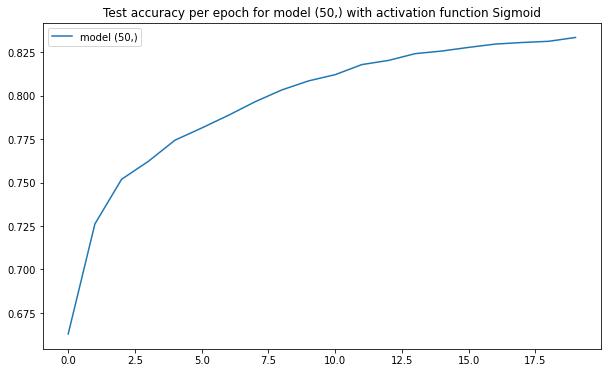

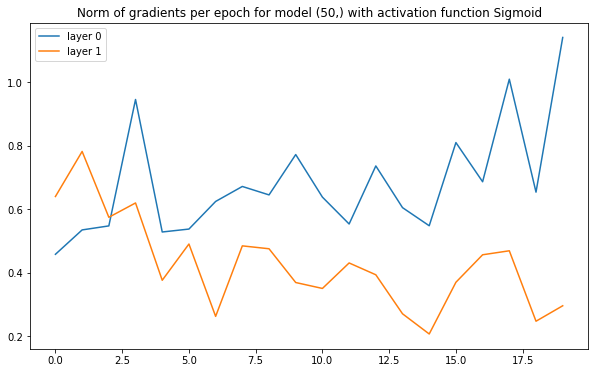

--------------------------------------------
Model (50, 30) with activation function Sigmoid:

epoch 0, accuracy=0.3729
epoch 1, accuracy=0.4308
epoch 2, accuracy=0.4485
epoch 3, accuracy=0.5033
epoch 4, accuracy=0.5590
epoch 5, accuracy=0.6167
epoch 6, accuracy=0.5996
epoch 7, accuracy=0.6244
epoch 8, accuracy=0.6416
epoch 9, accuracy=0.6679
epoch 10, accuracy=0.6870
epoch 11, accuracy=0.7063
epoch 12, accuracy=0.7204
epoch 13, accuracy=0.7269
epoch 14, accuracy=0.7354
epoch 15, accuracy=0.7420
epoch 16, accuracy=0.7462
epoch 17, accuracy=0.7501
epoch 18, accuracy=0.7532
epoch 19, accuracy=0.7560


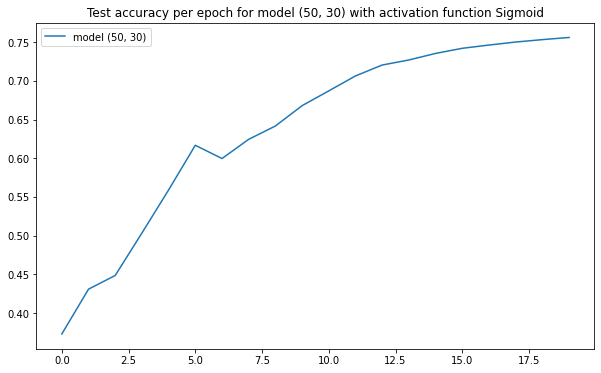

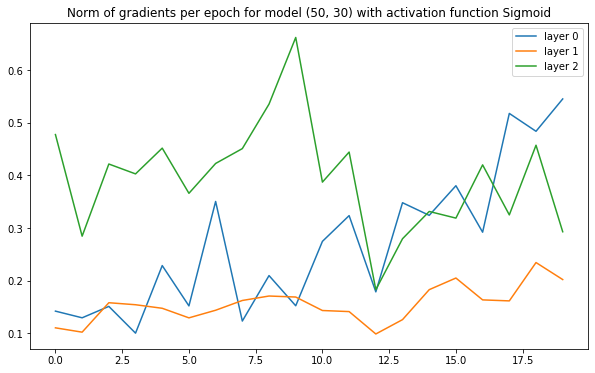

--------------------------------------------
Model (50, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.1178
epoch 1, accuracy=0.1022
epoch 2, accuracy=0.2398
epoch 3, accuracy=0.2418
epoch 4, accuracy=0.2743
epoch 5, accuracy=0.2320
epoch 6, accuracy=0.1435
epoch 7, accuracy=0.3161
epoch 8, accuracy=0.2839
epoch 9, accuracy=0.3403
epoch 10, accuracy=0.2757
epoch 11, accuracy=0.3561
epoch 12, accuracy=0.3980
epoch 13, accuracy=0.3382
epoch 14, accuracy=0.3400
epoch 15, accuracy=0.3298
epoch 16, accuracy=0.3688
epoch 17, accuracy=0.3646
epoch 18, accuracy=0.4005
epoch 19, accuracy=0.4198


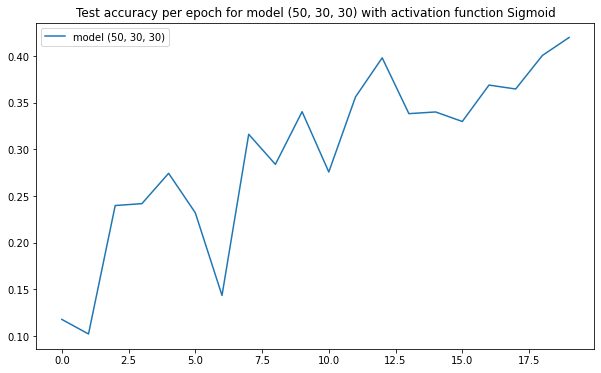

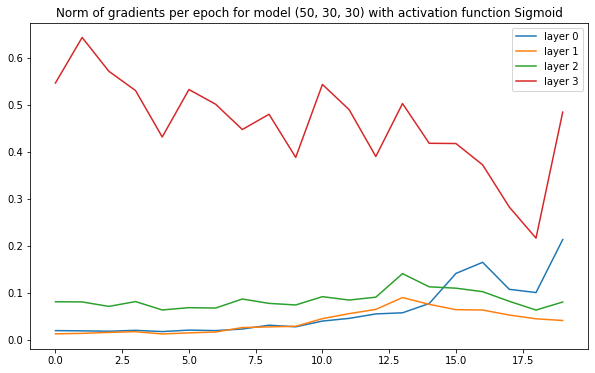

--------------------------------------------
Model (50, 30, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.1000
epoch 1, accuracy=0.1000
epoch 2, accuracy=0.1000
epoch 3, accuracy=0.1000
epoch 4, accuracy=0.1000
epoch 5, accuracy=0.1000
epoch 6, accuracy=0.1000
epoch 7, accuracy=0.1312
epoch 8, accuracy=0.1003
epoch 9, accuracy=0.1005
epoch 10, accuracy=0.1006
epoch 11, accuracy=0.1000
epoch 12, accuracy=0.1000
epoch 13, accuracy=0.1000
epoch 14, accuracy=0.1000
epoch 15, accuracy=0.1000
epoch 16, accuracy=0.1000
epoch 17, accuracy=0.1000
epoch 18, accuracy=0.1000
epoch 19, accuracy=0.1002


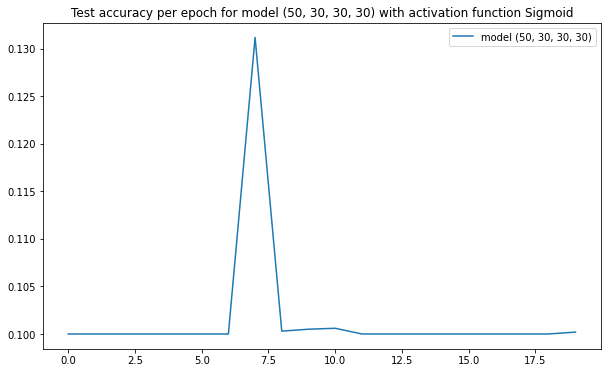

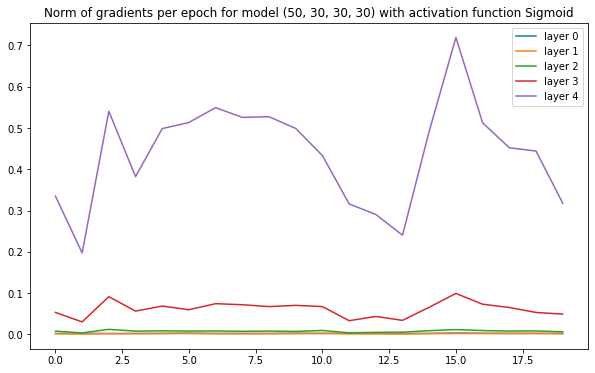

--------------------------------------------
Model (50,) with activation function Relu:

epoch 0, accuracy=0.7790
epoch 1, accuracy=0.8138
epoch 2, accuracy=0.8287
epoch 3, accuracy=0.8373
epoch 4, accuracy=0.8403
epoch 5, accuracy=0.8442
epoch 6, accuracy=0.8464
epoch 7, accuracy=0.8507
epoch 8, accuracy=0.8518
epoch 9, accuracy=0.8543
epoch 10, accuracy=0.8569
epoch 11, accuracy=0.8590
epoch 12, accuracy=0.8609
epoch 13, accuracy=0.8608
epoch 14, accuracy=0.8614
epoch 15, accuracy=0.8652
epoch 16, accuracy=0.8643
epoch 17, accuracy=0.8647
epoch 18, accuracy=0.8679
epoch 19, accuracy=0.8672


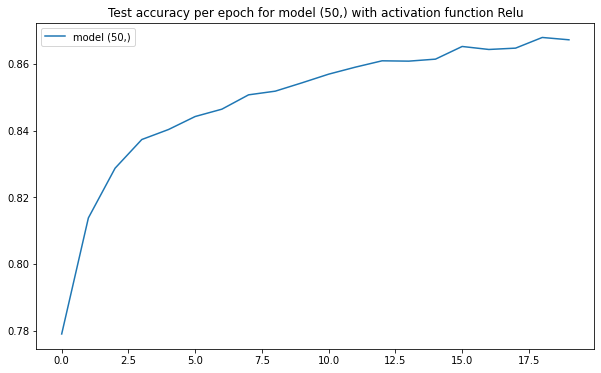

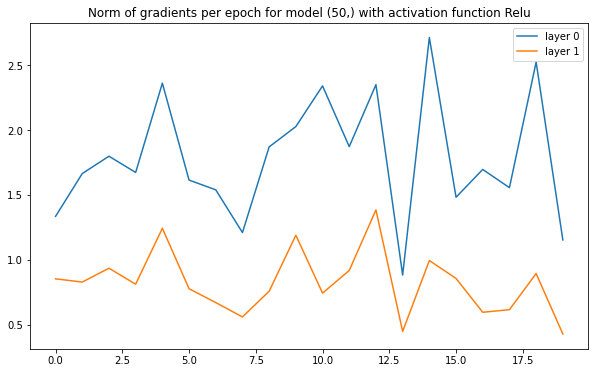

--------------------------------------------
Model (50, 30) with activation function Relu:

epoch 0, accuracy=0.7403
epoch 1, accuracy=0.7824
epoch 2, accuracy=0.8091
epoch 3, accuracy=0.8237
epoch 4, accuracy=0.8338
epoch 5, accuracy=0.8390
epoch 6, accuracy=0.8421
epoch 7, accuracy=0.8457
epoch 8, accuracy=0.8487
epoch 9, accuracy=0.8515
epoch 10, accuracy=0.8536
epoch 11, accuracy=0.8546
epoch 12, accuracy=0.8558
epoch 13, accuracy=0.8599
epoch 14, accuracy=0.8587
epoch 15, accuracy=0.8619
epoch 16, accuracy=0.8629
epoch 17, accuracy=0.8642
epoch 18, accuracy=0.8642
epoch 19, accuracy=0.8661


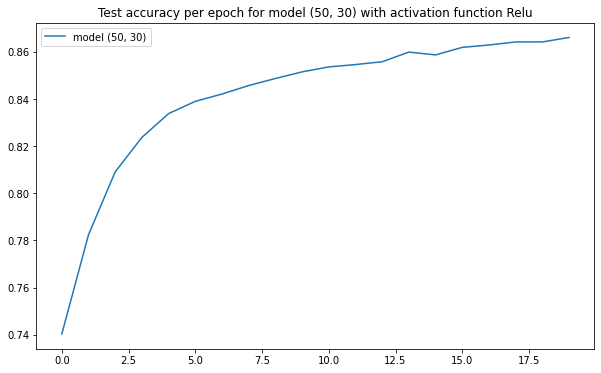

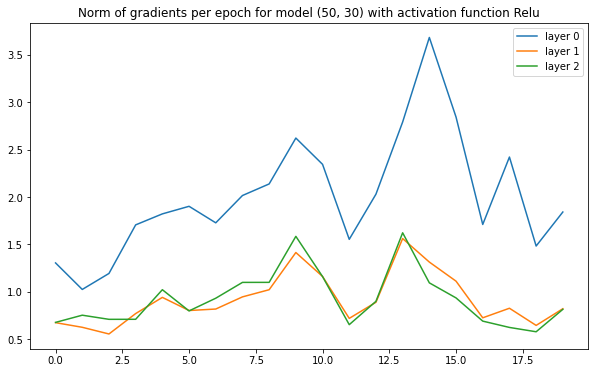

--------------------------------------------
Model (50, 30, 30) with activation function Relu:

epoch 0, accuracy=0.5732
epoch 1, accuracy=0.7269
epoch 2, accuracy=0.7714
epoch 3, accuracy=0.7996
epoch 4, accuracy=0.8217
epoch 5, accuracy=0.8304
epoch 6, accuracy=0.8339
epoch 7, accuracy=0.8439
epoch 8, accuracy=0.8461
epoch 9, accuracy=0.8492
epoch 10, accuracy=0.8539
epoch 11, accuracy=0.8574
epoch 12, accuracy=0.8585
epoch 13, accuracy=0.8604
epoch 14, accuracy=0.8642
epoch 15, accuracy=0.8619
epoch 16, accuracy=0.8660
epoch 17, accuracy=0.8673
epoch 18, accuracy=0.8639
epoch 19, accuracy=0.8681


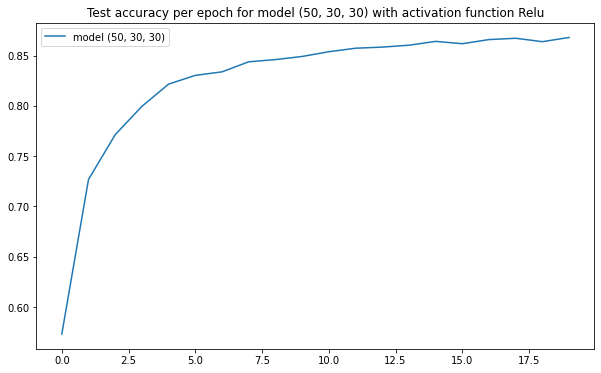

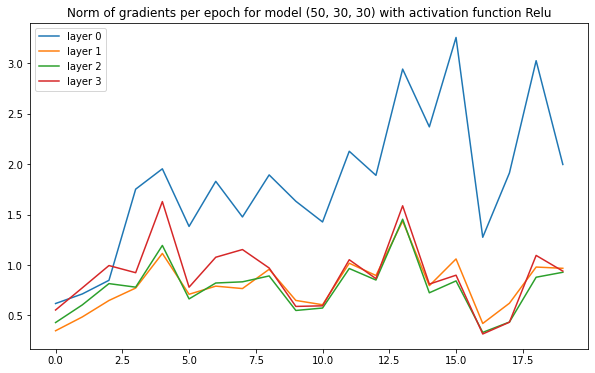

--------------------------------------------
Model (50, 30, 30, 30) with activation function Relu:

epoch 0, accuracy=0.3028
epoch 1, accuracy=0.5227
epoch 2, accuracy=0.7271
epoch 3, accuracy=0.7601
epoch 4, accuracy=0.7884
epoch 5, accuracy=0.7989
epoch 6, accuracy=0.8151
epoch 7, accuracy=0.8233
epoch 8, accuracy=0.8351
epoch 9, accuracy=0.8439
epoch 10, accuracy=0.8443
epoch 11, accuracy=0.8538
epoch 12, accuracy=0.8549
epoch 13, accuracy=0.8568
epoch 14, accuracy=0.8608
epoch 15, accuracy=0.8621
epoch 16, accuracy=0.8642
epoch 17, accuracy=0.8655
epoch 18, accuracy=0.8664
epoch 19, accuracy=0.8676


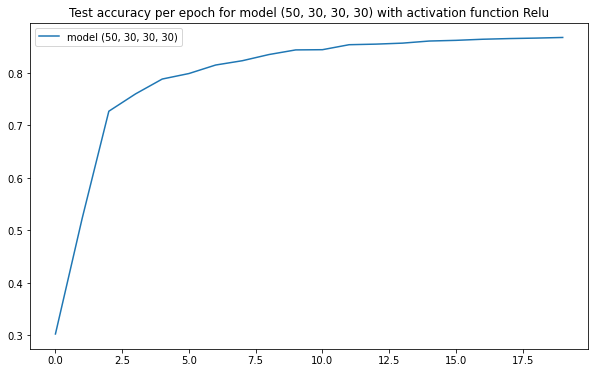

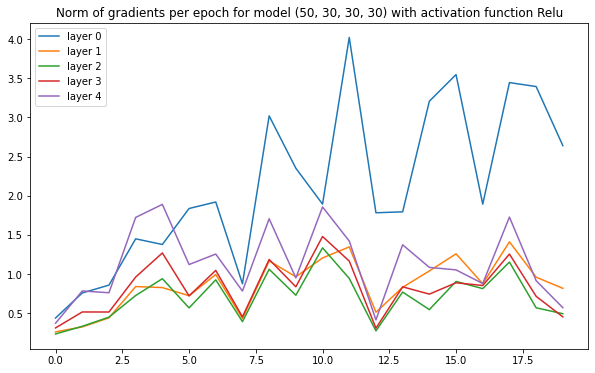

--------------------------------------------


In [12]:
# Task 2 and 3:

activation_functions=[torch.nn.Sigmoid,torch.nn.ReLU]
activation_functions_names=dict(zip(activation_functions,["Sigmoid", "Relu"]))
num_neurons_list=[(50,),(50,30),(50,30,30),(50,30,30,30)]

run (num_neurons_list, activation_functions, activation_functions_names, init_weight="default")

#### What we observe?
By using Relu as activation function, we observe that vanishing gradients doesn't happen in deeper networks, and the accuracy increases.


Model (50, 30, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.1085
epoch 1, accuracy=0.1298
epoch 2, accuracy=0.1832
epoch 3, accuracy=0.1225
epoch 4, accuracy=0.2465
epoch 5, accuracy=0.2424
epoch 6, accuracy=0.2612
epoch 7, accuracy=0.2497
epoch 8, accuracy=0.3342
epoch 9, accuracy=0.3223
epoch 10, accuracy=0.3411
epoch 11, accuracy=0.4254
epoch 12, accuracy=0.3605
epoch 13, accuracy=0.3133
epoch 14, accuracy=0.3468
epoch 15, accuracy=0.3661
epoch 16, accuracy=0.3114
epoch 17, accuracy=0.3520
epoch 18, accuracy=0.3352
epoch 19, accuracy=0.4057


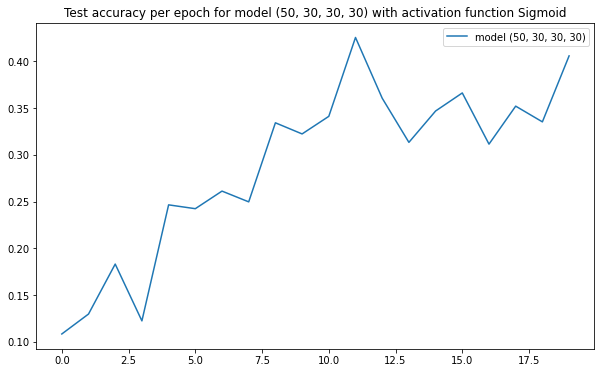

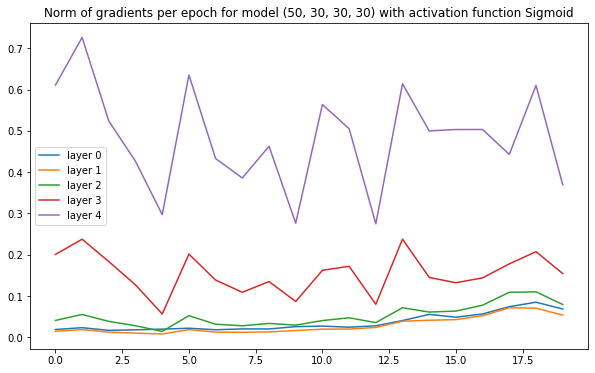

--------------------------------------------


In [13]:
# Task 4: Using xavier normal initialization and sigmoid as activation

activation_functions=[torch.nn.Sigmoid]
activation_functions_names=dict(zip(activation_functions,["Sigmoid"]))
num_neurons_list=[(50,30,30,30)]

run (num_neurons_list, activation_functions, activation_functions_names, init_weight="xavier")

#### Task 5:

Default weight initialization in Pytorch is based on the type of the layer that we have. For Linear layers, Pytorch uses kaiming uniform method for initialization.

In [ ]:
# Task 5: Re-ren all the models with xavier_normal_ initialization and sigmoid function to compare with default initialization

activation_functions=[torch.nn.Sigmoid]
activation_functions_names=dict(zip(activation_functions,["Sigmoid"]))
num_neurons_list=[(50,),(50,30),(50,30,30),(50,30,30,30)]

run (num_neurons_list, activation_functions, activation_functions_names, init_weight="xavier")

#### What we observe?

By using xavier_normal_ initialization with sigmoid function, the accuracy of models increased, in comparison to the default initialization.

In [ ]:
# Task 5: changing the parameters of default initialization to see if it helps or not
# we change the value of nonlinearity parameter from default 'leaky_relu' to 'relu'

In [ ]:
activation_functions=[torch.nn.Sigmoid]
activation_functions_names=dict(zip(activation_functions,["Sigmoid"]))
num_neurons_list=[(50,),(50,30),(50,30,30),(50,30,30,30)]

run (num_neurons_list, activation_functions, activation_functions_names, init_weight="default_relu")

#### What we observe?

Changing the nonlinearity parameter from 'leaky relu' to 'relu' in default initialization with sigmoid function prevented vanishing gradients, and increased the accuracy.

Model (50,) with activation function Sigmoid:

epoch 0, accuracy=0.7244
epoch 1, accuracy=0.7595
epoch 2, accuracy=0.7760
epoch 3, accuracy=0.7883
epoch 4, accuracy=0.7977
epoch 5, accuracy=0.8046
epoch 6, accuracy=0.8108
epoch 7, accuracy=0.8170
epoch 8, accuracy=0.8210
epoch 9, accuracy=0.8226
epoch 10, accuracy=0.8241
epoch 11, accuracy=0.8248
epoch 12, accuracy=0.8267
epoch 13, accuracy=0.8279
epoch 14, accuracy=0.8291
epoch 15, accuracy=0.8308
epoch 16, accuracy=0.8324
epoch 17, accuracy=0.8339
epoch 18, accuracy=0.8361
epoch 19, accuracy=0.8370


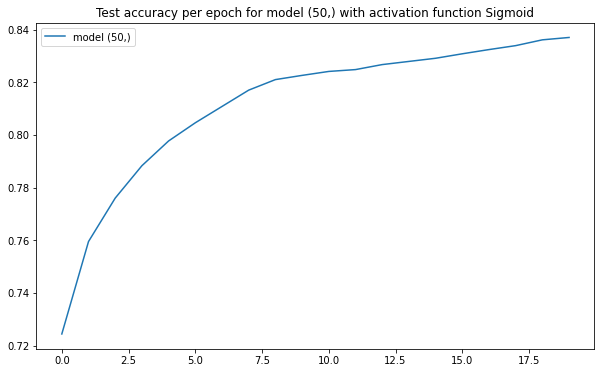

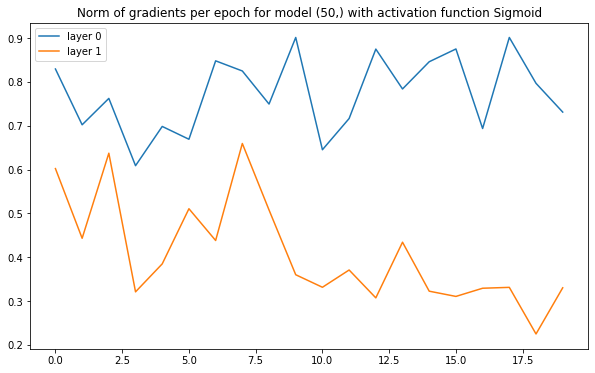

--------------------------------------------
Model (50, 30) with activation function Sigmoid:

epoch 0, accuracy=0.5287
epoch 1, accuracy=0.5756
epoch 2, accuracy=0.6319
epoch 3, accuracy=0.6603
epoch 4, accuracy=0.6808
epoch 5, accuracy=0.7036
epoch 6, accuracy=0.7163
epoch 7, accuracy=0.7284
epoch 8, accuracy=0.7338
epoch 9, accuracy=0.7413
epoch 10, accuracy=0.7467
epoch 11, accuracy=0.7531
epoch 12, accuracy=0.7577
epoch 13, accuracy=0.7647
epoch 14, accuracy=0.7678
epoch 15, accuracy=0.7728
epoch 16, accuracy=0.7769
epoch 17, accuracy=0.7799
epoch 18, accuracy=0.7845
epoch 19, accuracy=0.7897


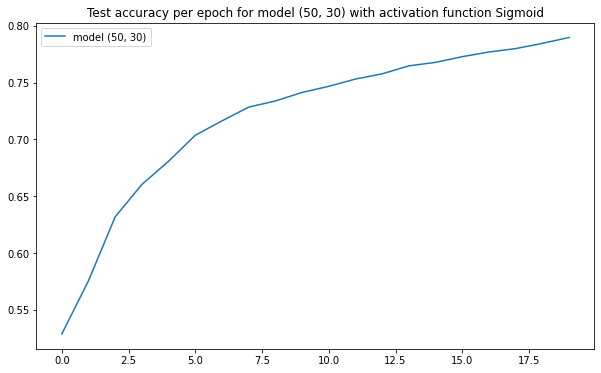

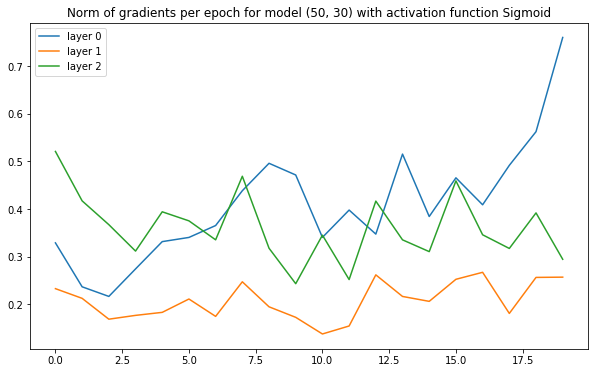

--------------------------------------------
Model (50, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.2527
epoch 1, accuracy=0.4169
epoch 2, accuracy=0.5060
epoch 3, accuracy=0.5110
epoch 4, accuracy=0.4785
epoch 5, accuracy=0.4736
epoch 6, accuracy=0.4652
epoch 7, accuracy=0.5436
epoch 8, accuracy=0.5582
epoch 9, accuracy=0.5838
epoch 10, accuracy=0.6165
epoch 11, accuracy=0.6317
epoch 12, accuracy=0.6459
epoch 13, accuracy=0.6622
epoch 14, accuracy=0.6811
epoch 15, accuracy=0.6846
epoch 16, accuracy=0.7084
epoch 17, accuracy=0.7117
epoch 18, accuracy=0.7208
epoch 19, accuracy=0.7243


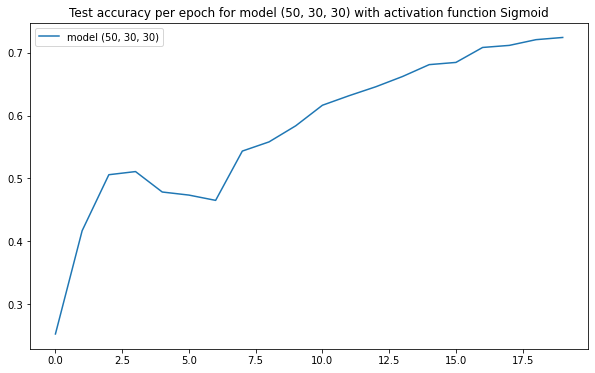

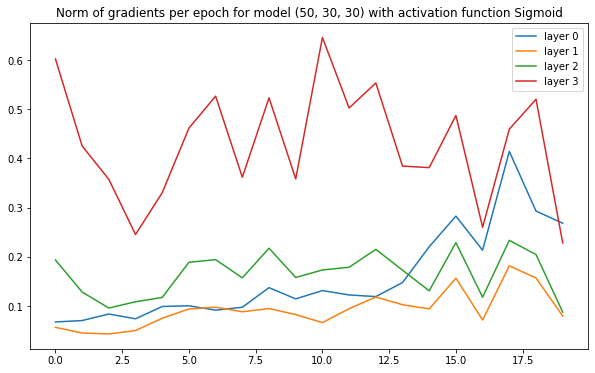

--------------------------------------------
Model (50, 30, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.1052
epoch 1, accuracy=0.1733
epoch 2, accuracy=0.1006
epoch 3, accuracy=0.3193
epoch 4, accuracy=0.1881
epoch 5, accuracy=0.2721
epoch 6, accuracy=0.1998
epoch 7, accuracy=0.2665
epoch 8, accuracy=0.2663
epoch 9, accuracy=0.2775
epoch 10, accuracy=0.2214
epoch 11, accuracy=0.2011
epoch 12, accuracy=0.2224
epoch 13, accuracy=0.2495
epoch 14, accuracy=0.2213
epoch 15, accuracy=0.2348
epoch 16, accuracy=0.2474
epoch 17, accuracy=0.2588
epoch 18, accuracy=0.2717
epoch 19, accuracy=0.2655


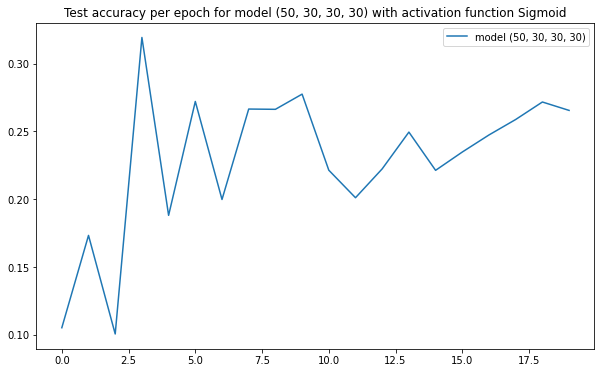

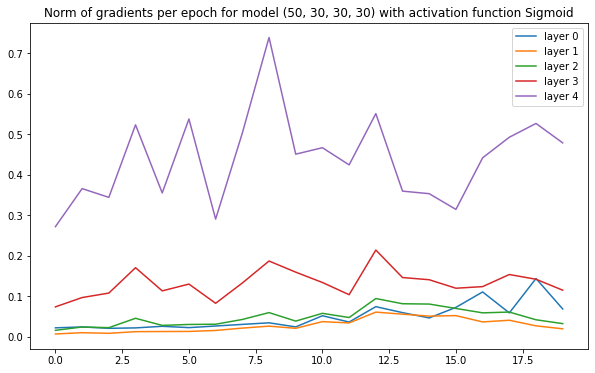

--------------------------------------------


#### What we observe?

By using xavier_normal_ initialization with sigmoid function, the accuracy of models increased, in comparison to the default initialization.

In [15]:
# Task 5: changing the parameters of default initialization to see if it helps or not
# we change the value of nonlinearity parameter from default 'leaky_relu' to 'relu'

Model (50,) with activation function Sigmoid:

epoch 0, accuracy=0.7302
epoch 1, accuracy=0.7601
epoch 2, accuracy=0.7751
epoch 3, accuracy=0.7863
epoch 4, accuracy=0.7937
epoch 5, accuracy=0.7994
epoch 6, accuracy=0.8053
epoch 7, accuracy=0.8107
epoch 8, accuracy=0.8138
epoch 9, accuracy=0.8178
epoch 10, accuracy=0.8199
epoch 11, accuracy=0.8220
epoch 12, accuracy=0.8242
epoch 13, accuracy=0.8270
epoch 14, accuracy=0.8288
epoch 15, accuracy=0.8294
epoch 16, accuracy=0.8314
epoch 17, accuracy=0.8323
epoch 18, accuracy=0.8347
epoch 19, accuracy=0.8359


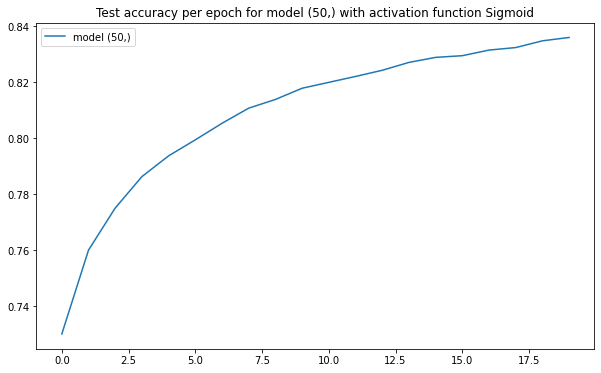

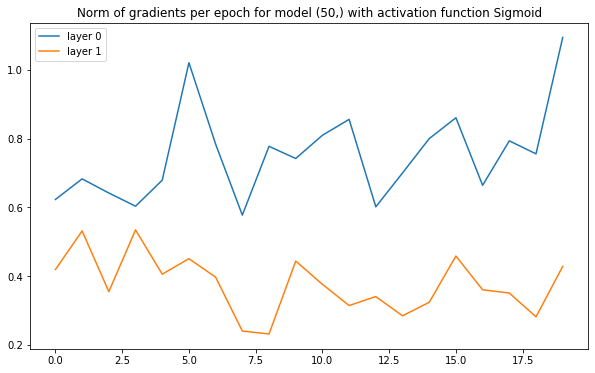

--------------------------------------------
Model (50, 30) with activation function Sigmoid:

epoch 0, accuracy=0.5542
epoch 1, accuracy=0.6668
epoch 2, accuracy=0.7136
epoch 3, accuracy=0.7298
epoch 4, accuracy=0.7395
epoch 5, accuracy=0.7455
epoch 6, accuracy=0.7501
epoch 7, accuracy=0.7589
epoch 8, accuracy=0.7638
epoch 9, accuracy=0.7690
epoch 10, accuracy=0.7723
epoch 11, accuracy=0.7757
epoch 12, accuracy=0.7791
epoch 13, accuracy=0.7829
epoch 14, accuracy=0.7863
epoch 15, accuracy=0.7899
epoch 16, accuracy=0.7937
epoch 17, accuracy=0.7970
epoch 18, accuracy=0.8016
epoch 19, accuracy=0.8062


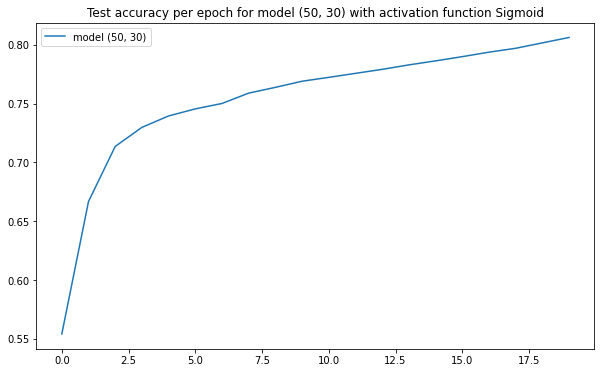

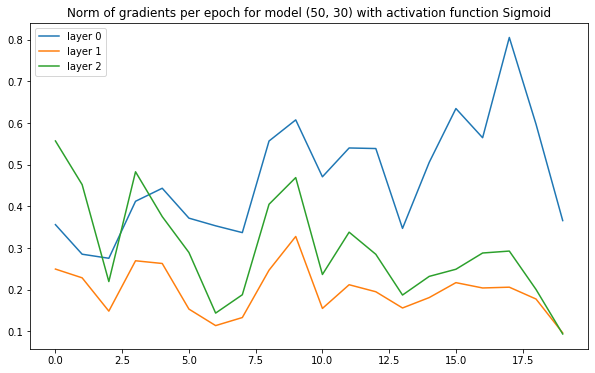

--------------------------------------------
Model (50, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.4370
epoch 1, accuracy=0.4527
epoch 2, accuracy=0.4946
epoch 3, accuracy=0.5022
epoch 4, accuracy=0.4914
epoch 5, accuracy=0.5215
epoch 6, accuracy=0.5617
epoch 7, accuracy=0.5805
epoch 8, accuracy=0.5965
epoch 9, accuracy=0.6192
epoch 10, accuracy=0.6354
epoch 11, accuracy=0.6528
epoch 12, accuracy=0.6653
epoch 13, accuracy=0.6945
epoch 14, accuracy=0.7003
epoch 15, accuracy=0.7088
epoch 16, accuracy=0.7260
epoch 17, accuracy=0.7341
epoch 18, accuracy=0.7422
epoch 19, accuracy=0.7454


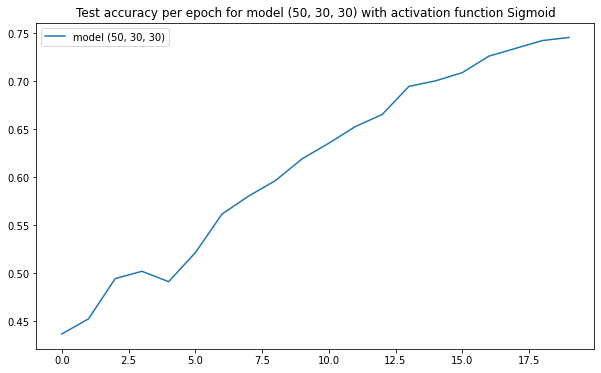

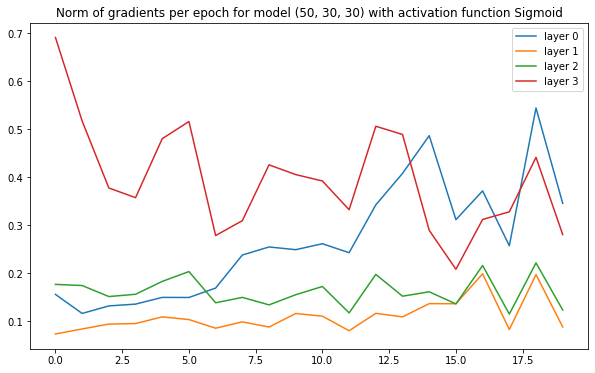

--------------------------------------------
Model (50, 30, 30, 30) with activation function Sigmoid:

epoch 0, accuracy=0.1813
epoch 1, accuracy=0.2139
epoch 2, accuracy=0.2692
epoch 3, accuracy=0.2158
epoch 4, accuracy=0.2131
epoch 5, accuracy=0.2184
epoch 6, accuracy=0.2236
epoch 7, accuracy=0.2194
epoch 8, accuracy=0.2416
epoch 9, accuracy=0.2647
epoch 10, accuracy=0.3476
epoch 11, accuracy=0.2816
epoch 12, accuracy=0.3435
epoch 13, accuracy=0.3589
epoch 14, accuracy=0.3896
epoch 15, accuracy=0.4070
epoch 16, accuracy=0.4104
epoch 17, accuracy=0.3725
epoch 18, accuracy=0.3692
epoch 19, accuracy=0.4270


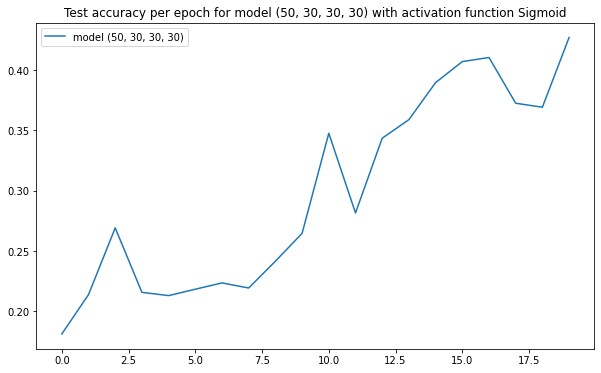

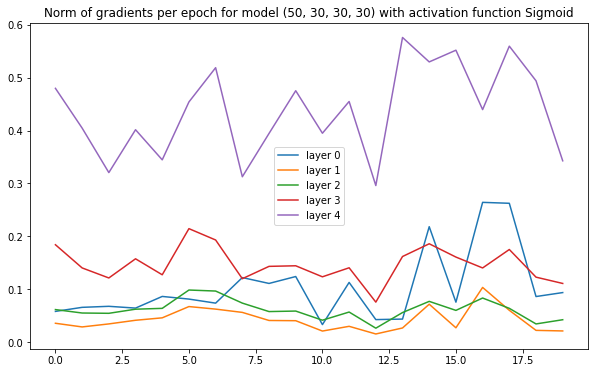

--------------------------------------------


In [16]:
activation_functions=[torch.nn.Sigmoid]
activation_functions_names=dict(zip(activation_functions,["Sigmoid"]))
num_neurons_list=[(50,),(50,30),(50,30,30),(50,30,30,30)]

run (num_neurons_list, activation_functions, activation_functions_names, init_weight="default_relu")

#### What we observe?

Changing the nonlinearity parameter from 'leaky relu' to 'relu' in default initialization with sigmoid function prevented vanishing gradients, and increased the accuracy.